# Analyse the relationship between Bouguer and topography

In [1]:
%matplotlib inline
from __future__ import division, print_function
import datetime
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from fatiando import utils, constants

In [2]:
datapath = 'data/{}'
datafile = 'processed-tim_r5-africa-1deg.txt'
outfile = 'residual-regional-tim_r5-africa-1deg.txt'

## Load processed data

Data processed by [data_processing.ipynb](data_processing.ipynb)

In [3]:
with open(datapath.format(datafile)) as f:
    # Read the projection and the shape from the header
    for i in range(5):
        line = f.readline()
    line = f.readline()
    parts = line.split(':')
    projection = parts[1].strip()
    line = f.readline()
    parts = line.split(':')
    shape = eval(parts[1].strip())
    # Load the numeric data
    lat, lon, x, y, height, topo, bouguer = np.loadtxt(f, unpack=True, usecols=[0, 1, 2, 3, 4, 7, 10])
    x = x.reshape(shape)
    y = y.reshape(shape)

In [4]:
s, n, w, e = area = lat.min(), lat.max(), lon.min(), lon.max()

In [5]:
bm = Basemap(projection=projection, llcrnrlat=s, llcrnrlon=w, urcrnrlat=n, urcrnrlon=e, lat_ts=(n + s)/2)

In [6]:
def plot_map(data, cmap, cmlabel):
    plt.figure(figsize=(8, 7))
    bm.contourf(y, x, data.reshape(shape), 50, cmap=cmap)
    cb = plt.colorbar()
    cb.set_label(cmlabel)
    bm.drawmeridians(np.arange(w, e, 20), labels=[0, 0, 0, 1])
    bm.drawparallels(np.arange(s, n, 20), labels=[1, 0, 0, 0])
    bm.drawcoastlines(color='grey')

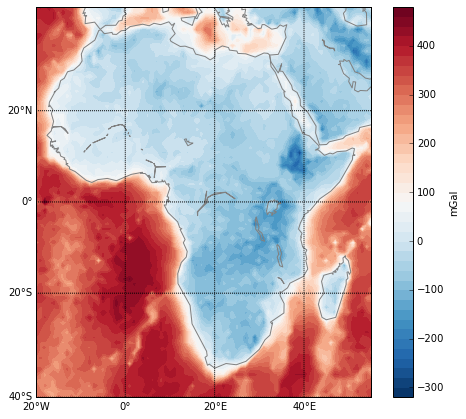

In [7]:
plot_map(bouguer, 'RdBu_r', 'mGal')

## Bouguer vs topography

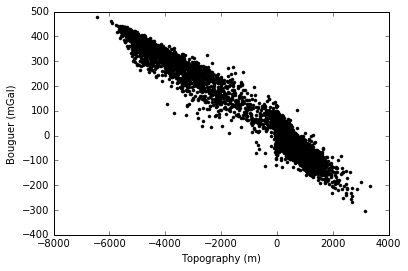

In [8]:
plt.figure()
plt.plot(topo, bouguer, '.k')
plt.xlabel('Topography (m)')
plt.ylabel('Bouguer (mGal)')

Create the equivalent topography using the densities defined below.

In [9]:
rhoa = 1040
rhoc = 2670
topo_eq = np.copy(topo)
topo_eq[topo < 0] = topo[topo < 0]*(rhoc - rhoa)/rhoc

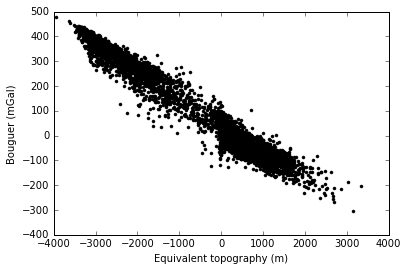

In [10]:
plt.figure()
plt.plot(topo_eq, bouguer, '.k')
plt.xlabel('Equivalent topography (m)')
plt.ylabel('Bouguer (mGal)')

Fit a line to the equivalent topography and Bouguer.

In [11]:
def robust_regression(x, y, maxit=10):
    weight = None
    for i in range(maxit):
        a, b = sp.polyfit(x, y, w=weight, deg=1)
        residuals = y - (a*x + b)
        residuals[np.abs(residuals) < 1e-10] = 1e-10
        weight = 1/np.abs(residuals)
    return a, b, a*x + b        

In [12]:
a, b, line = robust_regression(topo_eq, bouguer)
print('bouguer = {}*t_eq + {}'.format(a, b))

bouguer = -0.114511006635*t_eq + 31.8201057515


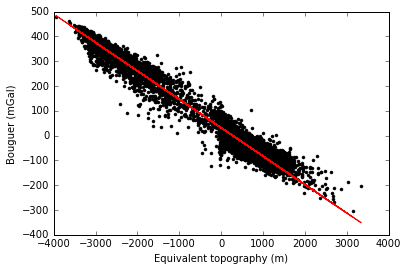

In [13]:
plt.figure()
plt.plot(topo_eq, bouguer, '.k')
plt.plot(topo_eq, line, '-r')
plt.xlabel('Equivalent topography (m)')
plt.ylabel('Bouguer (mGal)')

In [14]:
crustal_density = -utils.mgal2si(a)/(2*np.pi*constants.G)
print('Estimated crustal density: {} kg.m^-3'.format(crustal_density))

Estimated crustal density: 2731.15431505 kg.m^-3


In [15]:
isostatic_moho_grav = line
crustal_grav = bouguer - isostatic_moho_grav

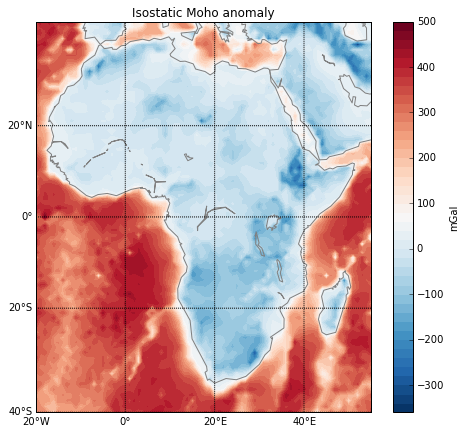

In [16]:
plot_map(isostatic_moho_grav, 'RdBu_r', 'mGal')
plt.title('Isostatic Moho anomaly')

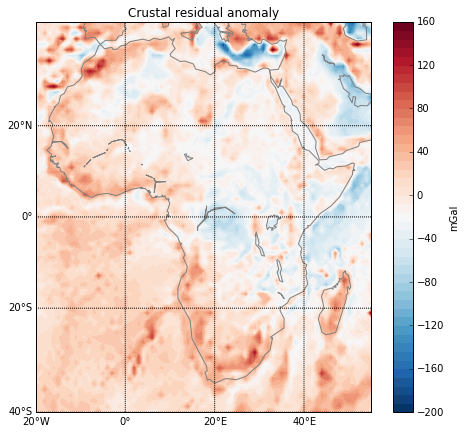

In [17]:
plot_map(crustal_grav, 'RdBu_r', 'mGal')
plt.title('Crustal residual anomaly')

## Window analysis

Create some functions to slice our data using a moving window scheme.

In [18]:
def inside(x, y, area):
    x1, x2, y1, y2 = area
    return ((x >= x1) & (x <= x2) & (y >= y1) & (y <= y2))


def moving_window(x, y, size, shape=None, overlap=None, return_center=False):
    if shape is None and overlap is None:
        raise ValueError('Need either the number of windows (shape) '
                         + 'or the percentage of overlap between them.')
    area = x1, x2, y1, y2 = [x.min(), x.max(), y.min(), y.max()]
    dx, dy = size
    if shape is None:
        stepx = (1 - overlap)*dx
        stepy = (1 - overlap)*dy
        shape = (int((area[1] - area[0] - dx)/stepx) + 1,
                 int((area[3] - area[2] - dy)/stepy) + 1)
    nx, ny = shape    
    centers = []
    xmidpoints = np.linspace(x1 + dx/2, x2 - dx/2, nx)
    ymidpoints = np.linspace(y1 + dy/2, y2 - dy/2, ny)
    for xc in xmidpoints:
        for yc in ymidpoints:
            window = [xc - dx/2, xc + dx/2, yc - dy/2, yc + dy/2]
            is_inside = inside(x, y, window)
            if return_center:
                yield is_inside, xc, yc
            else:
                yield is_inside

Now run the robust regression on each window and capture the coefficients. Also store the coordinates of the center of each window for plotting later.

In [19]:
%%time
outputs = []
windows = []
for window, latc, lonc in moving_window(lat, lon, (5, 5), overlap=0.75, return_center=True):
    a, b, line = robust_regression(topo_eq[window], bouguer[window], maxit=5)
    outputs.append([a, b, latc, lonc])
    windows.append(window)
angular_coefs, linear_coefs, lat_coefs, lon_coefs = np.array(outputs).T

CPU times: user 3.47 s, sys: 16 ms, total: 3.48 s
Wall time: 3.48 s


Calculate the crustal density from the estimated angular coefficients.

In [20]:
rhoc = -utils.mgal2si(angular_coefs)/(2*np.pi*constants.G)

Plot the linear and angular coefficients on a map.

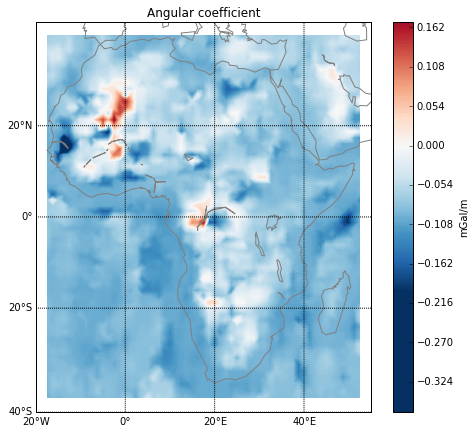

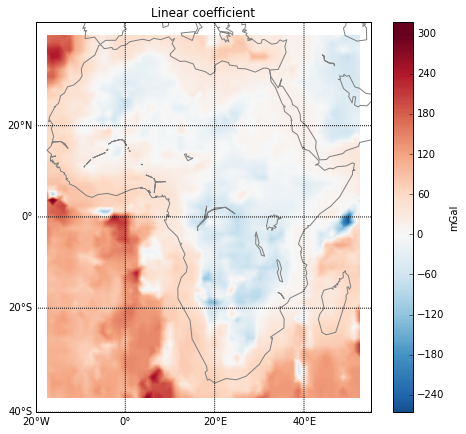

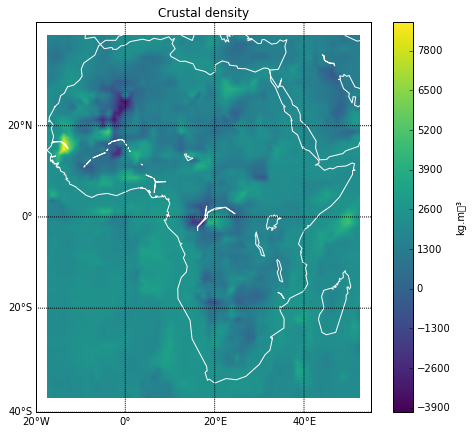

In [24]:
yc, xc = bm(lon_coefs, lat_coefs)

plt.figure(figsize=(8, 7))
plt.title('Angular coefficient')
bm.contourf(yc, xc, angular_coefs, 300, tri=True, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
cb = plt.colorbar()
cb.set_label('mGal/m')
bm.drawmeridians(np.arange(w, e, 20), labels=[0, 0, 0, 1])
bm.drawparallels(np.arange(s, n, 20), labels=[1, 0, 0, 0])
bm.drawcoastlines(color='grey')

plt.figure(figsize=(8, 7))
plt.title('Linear coefficient')
bm.contourf(yc, xc, linear_coefs, 300, tri=True, cmap='RdBu_r', vmin=-300, vmax=300)
cb = plt.colorbar()
cb.set_label('mGal')
bm.drawmeridians(np.arange(w, e, 20), labels=[0, 0, 0, 1])
bm.drawparallels(np.arange(s, n, 20), labels=[1, 0, 0, 0])
bm.drawcoastlines(color='grey')

plt.figure(figsize=(8, 7))
plt.title('Crustal density')
bm.contourf(yc, xc, rhoc, 300, tri=True, cmap='viridis')
cb = plt.colorbar()
cb.set_label(u'kg.m⁻³')
bm.drawmeridians(np.arange(w, e, 20), labels=[0, 0, 0, 1])
bm.drawparallels(np.arange(s, n, 20), labels=[1, 0, 0, 0])
bm.drawcoastlines(color='white')

Plot the regression graphs for selected windows.

Regression plots for different windows (lat, lon)


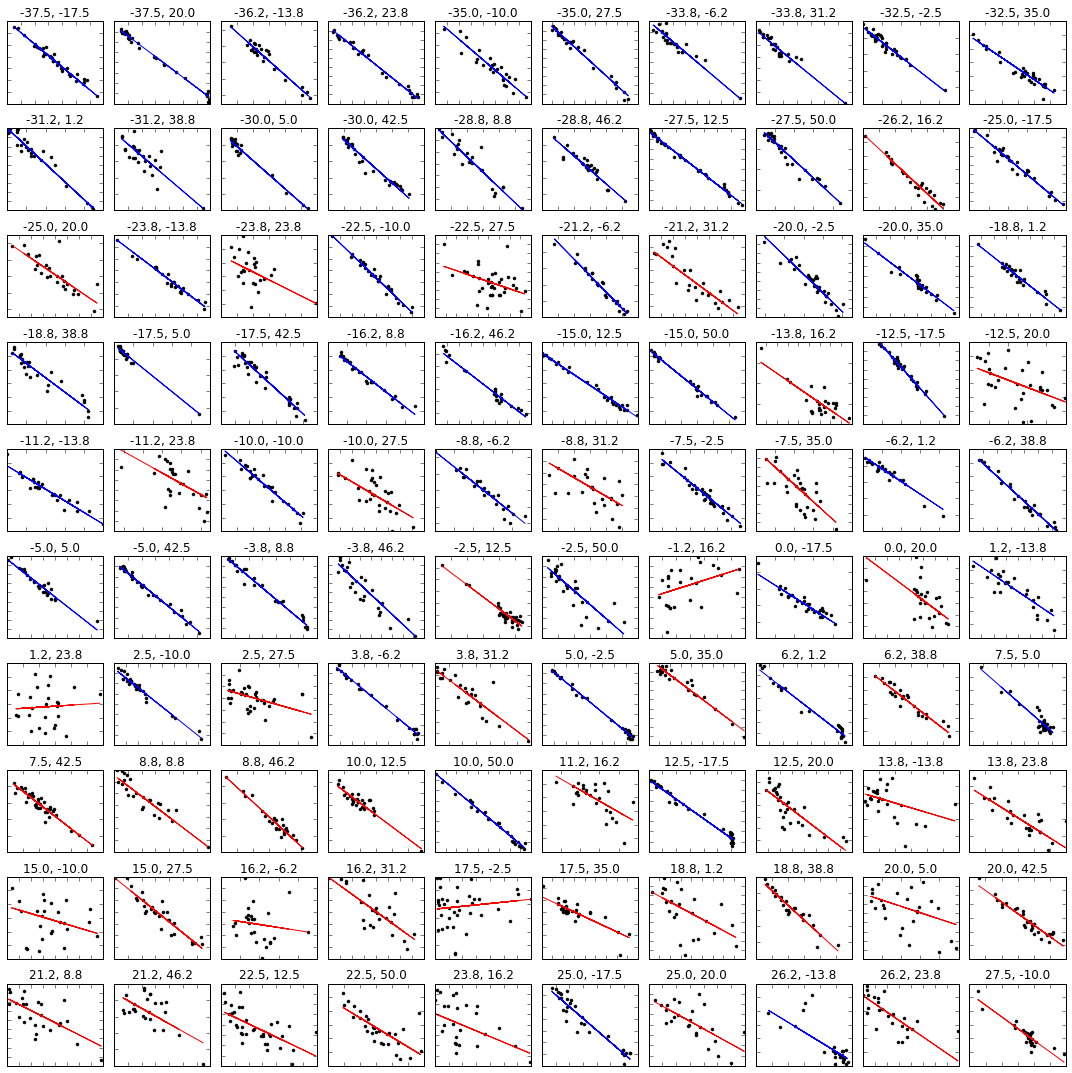

In [27]:
print('Regression plots for different windows (lat, lon)')
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i, ax in enumerate(axes.ravel()):
    index = i*30
    a, b = angular_coefs[index], linear_coefs[index]
    window = windows[index]
    ax.plot(topo_eq[window], bouguer[window], '.k')
    if topo[window].mean() < 0:
        color = '-b'
    else:
        color = '-r'
    ax.plot(topo_eq[window], a*topo_eq[window] + b, color, linewidth=1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('{:.1f}, {:.1f}'.format(lat_coefs[index], lon_coefs[index]))
plt.tight_layout()

## Save the output

In [23]:
date = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
header = """# Generated by {notebook}.ipynb
# Date: {date}
# Processed gravity data: {datafile}
# Projection: {proj}
# Grid shape: {shape}
# Columns: lat  lon  x  y  height  topo  isostatic_moho_anomaly  crustal_residual_anomaly
""".format(notebook='isostatic_analysis',
           date=date, 
           datafile=datafile,
           proj=bm.projection,
           shape=shape)
with open(datapath.format(outfile), 'w') as f:
    f.write(header)
    datamatrix = np.array([lat, lon, x.ravel(), y.ravel(), height, topo, isostatic_moho_grav, crustal_grav]).T
    np.savetxt(f, datamatrix, fmt='%.4f')